In [146]:
import networkx as nx
import random
from matplotlib import pyplot as plt
from functools import wraps
import time
import math
import scipy
import os

In [104]:
def timeit(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.perf_counter()
        result = func(*args, **kwargs)
        end = time.perf_counter()
        print(f"{func.__name__} took {end - start:.6f} seconds")
        return result
    return wrapper

In [105]:
def initialize(G, terminals):
    subgraph = G.subgraph(terminals)
    
    if not nx.is_connected(subgraph):
        H = nx.Graph()
    
        for u in terminals:
            for v in terminals:
                if u != v:
                    path = nx.shortest_path(G, u, v, weight = "weight")
                    nx.add_path(H, path)
        subgraph = H
    
    best_tree = nx.minimum_spanning_tree(subgraph, weight = "weight")
    best_w = best_tree.size(weight = "weight")
    best_nodes = set(best_tree.nodes())
    
    return best_tree, best_w, best_nodes

In [166]:
@timeit
def simulated_annealing(G, terminals, iterations, T0, alpha):
    current_tree, current_w, current_nodes = initialize(G, terminals)
    best_tree, best_w = current_tree, current_w
    nodes = list(set(G.nodes()) - set(terminals))
    T = T0

    for _ in range(iterations):
        v = random.choice(nodes)

        if random.random() < 0.5:
            candidate_nodes = current_nodes | {v}        
        else:
            candidate_nodes = (current_nodes - {v}) | set(terminals)
        
        subgraph = G.subgraph(candidate_nodes)
        
        if nx.is_connected(subgraph):
            new_tree = nx.minimum_spanning_tree(subgraph, weight = 'weight')
            new_w = new_tree.size(weight = 'weight')
            delta = new_w - current_w
            if delta < 0 or random.random() < math.exp(-delta / T):
                current_tree, current_w = new_tree, new_w
                current_nodes = set(new_tree.nodes())
                if current_w < best_w:
                    best_tree, best_w = current_tree, current_w
        T *= alpha

    return best_tree, best_w

In [55]:
K5 = nx.Graph()
edgesK5 = [
    (0, 1, 28), (0, 2, 13), (0, 3, 13), (0, 4, 22),
    (1, 2, 27), (1, 3, 28), (1, 4, 13),
    (2, 3, 19), (2, 4, 14),
    (3, 4, 19)
]
K5.add_weighted_edges_from(edgesK5)

In [56]:
K5best = nx.Graph()
edgesK5best = [
    (0, 1, 18), (0, 2, 20), (0, 3, 22), (0, 5, 10), (0, 6, 32), (0, 7, 29),
    (1, 2, 12), (1, 3, 18), (1, 4, 20), (1, 5, 29), (1, 6, 36), (1, 7, 10),
    (2, 3, 40), (2, 4, 20), (2, 5, 22), (2, 6, 21), (2, 7, 23),
    (3, 4, 22), (3, 5, 22), (3, 6, 40), (3, 7, 22),
    (4, 5, 23), (4, 6, 32), (4, 7, 20),
    (5, 6, 21), (5, 7, 33),
    (6, 7, 11)
]
K5best.add_weighted_edges_from(edgesK5best)

In [57]:
CS4234_2 = nx.Graph()
edgesCS4234_2 = [
    (0, 1, 14), (0, 3, 14), (0, 6, 8),
    (1, 2, 14), (1, 6, 14),
    (2, 3, 14), (2, 4, 10), (2, 5, 8),
    (3, 5, 8),
    (4, 2, 10),
    (5, 6, 6),
    (6, 0, 8)
]
CS4234_2.add_weighted_edges_from(edgesCS4234_2)

simulated_annealing took 0.031858 seconds


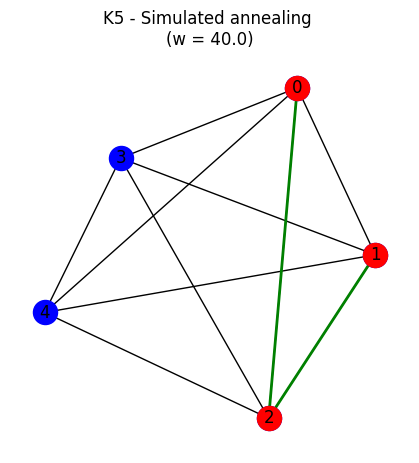

simulated_annealing took 0.014464 seconds


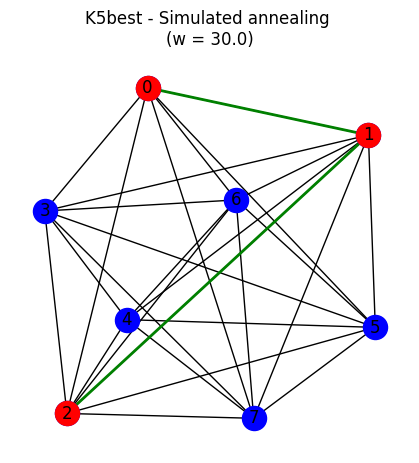

simulated_annealing took 0.012518 seconds


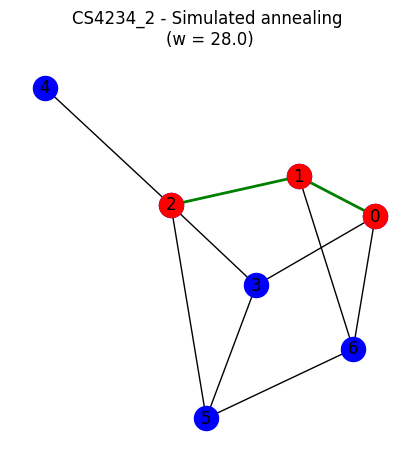

In [60]:
GS = [K5, K5best, CS4234_2]
names = ["K5", "K5best", "CS4234_2"]
terminals = [0,1,2]
for G, name in zip(GS, names): 
    pos = nx.spring_layout(G, seed = 42)
    T, w = simulated_annealing(G, terminals)
    
    plt.figure(figsize = (4,4))
    nx.draw(G, pos, with_labels = True, node_color = 'blue')
    nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
    nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
   # edge_labels = nx.get_edge_attributes(G, "weight") 
   # nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

    plt.title(f"{name} - Simulated annealing \n(w = {w})")
    plt.show()

In [151]:
def read_stp(filename):
    G = nx.Graph()
    terminals = set()
    
    with open(filename, 'r') as f:
        for line in f:
            line = line.strip()
            if line.startswith('E'):
                parts = line.split()
                u, v, w = int(parts[1]), int(parts[2]), int(parts[3])
                G.add_edge(u, v, weight = w)
            elif line.startswith('T'):
                terminals.add(int(line.split()[1]))
                
    return G, terminals

In [169]:
def tests(directory):
    results = {}
    
    for fname in os.listdir(directory):
        if fname.endswith(".stp"):
            path = os.path.join(directory, fname)
            try:
                G, terminals = read_stp(path) 
                results[fname] = (G, terminals)
                print(f"{fname} : (čvorova = {G.number_of_nodes()}, grana = {G.number_of_edges()}, terminala = {len(terminals)})")
                testiraj(G, terminals)
            except Exception as e:
                print(f"Greška u fajlu {fname}: {e}")
        print("\n")
    return 

In [182]:
def testiraj(G, terminals):
    num_iterations = [10,100,1000]
    T0s = [100,500, 1000]
    alphas = [0.90, 0.95, 0.99]
    for iterations in num_iterations:
        print("-----------------------------")
        for T0 in T0s:
            for alpha in alphas:
                best_tree, best_w = simulated_annealing(G, terminals, iterations, T0 = 100, alpha = 0.90)
                print(f'Simulirano kaljenje daje optimalnu tezinu: {best_w} za {iterations} iteracija, {T0} pocetnu temperaturu i alfa = {alpha}\n')

In [183]:
tests('InitialTest')

hc6u.stp : (čvorova = 64, grana = 192, terminala = 32)
-----------------------------
simulated_annealing took 0.110901 seconds
Simulirano kaljenje daje optimalnu tezinu: 58.0 za 10 iteracija, 100 pocetnu temperaturu i alfa = 0.9

simulated_annealing took 0.112173 seconds
Simulirano kaljenje daje optimalnu tezinu: 58.0 za 10 iteracija, 100 pocetnu temperaturu i alfa = 0.95

simulated_annealing took 0.113575 seconds
Simulirano kaljenje daje optimalnu tezinu: 59.0 za 10 iteracija, 100 pocetnu temperaturu i alfa = 0.99

simulated_annealing took 0.105991 seconds
Simulirano kaljenje daje optimalnu tezinu: 58.0 za 10 iteracija, 500 pocetnu temperaturu i alfa = 0.9

simulated_annealing took 0.112408 seconds
Simulirano kaljenje daje optimalnu tezinu: 58.0 za 10 iteracija, 500 pocetnu temperaturu i alfa = 0.95

simulated_annealing took 0.119743 seconds
Simulirano kaljenje daje optimalnu tezinu: 60.0 za 10 iteracija, 500 pocetnu temperaturu i alfa = 0.99

simulated_annealing took 0.116188 seconds

In [81]:
G, terminals = read_stp('hc12u.stp')
#print("Nodes:", G.nodes())
#print("Edges:", G.edges(data=True))
#print("Terminals:", terminals)

simulated_annealing took 16231.402139 seconds


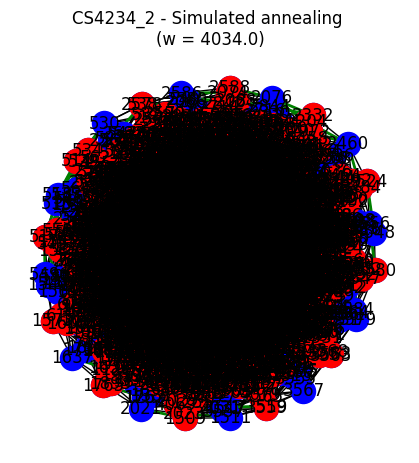

In [86]:
pos = nx.spring_layout(G, seed = 42)
T, w = simulated_annealing(G, terminals)
    
plt.figure(figsize = (4,4))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
   # edge_labels = nx.get_edge_attributes(G, "weight") 
   # nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

plt.title(f"{name} - Simulated annealing \n(w = {w})")
plt.show()

simulated_annealing took 0.224647 seconds


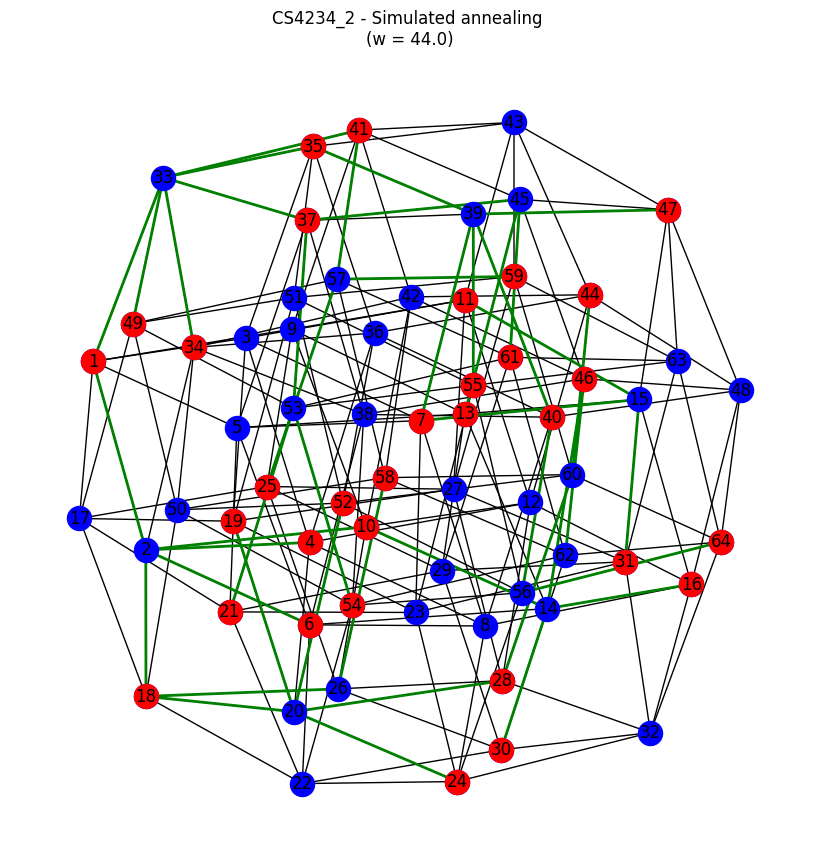

In [145]:
pos = nx.spring_layout(G, seed = 42)
T, w = simulated_annealing(G, terminals, iterations = 100)
    
plt.figure(figsize = (8,8))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
 
plt.title(f"{name} - Simulated annealing \n(w = {w})")
plt.show()
#Note: Na 100 iteracija ne moze da dodje do optimalnog - 39, na 1000 moze

simulated_annealing took 0.963525 seconds


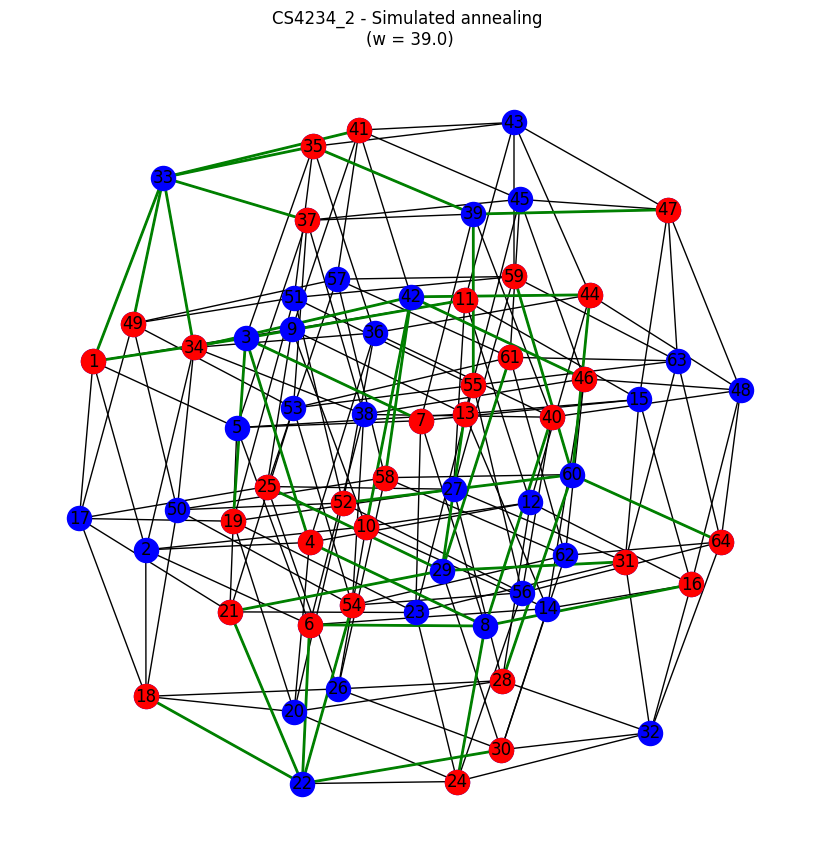

In [98]:
pos = nx.spring_layout(G, seed = 42)
T, w = simulated_annealing(G, terminals, iterations = 1000)
    
plt.figure(figsize = (8,8))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
   # edge_labels = nx.get_edge_attributes(G, "weight") 
   # nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

plt.title(f"{name} - Simulated annealing \n(w = {w})")
plt.show()
#Note: Na 100 iteracija ne moze da dodje do optimalnog - 39, na 1000 moze

simulated_annealing took 7.349089 seconds


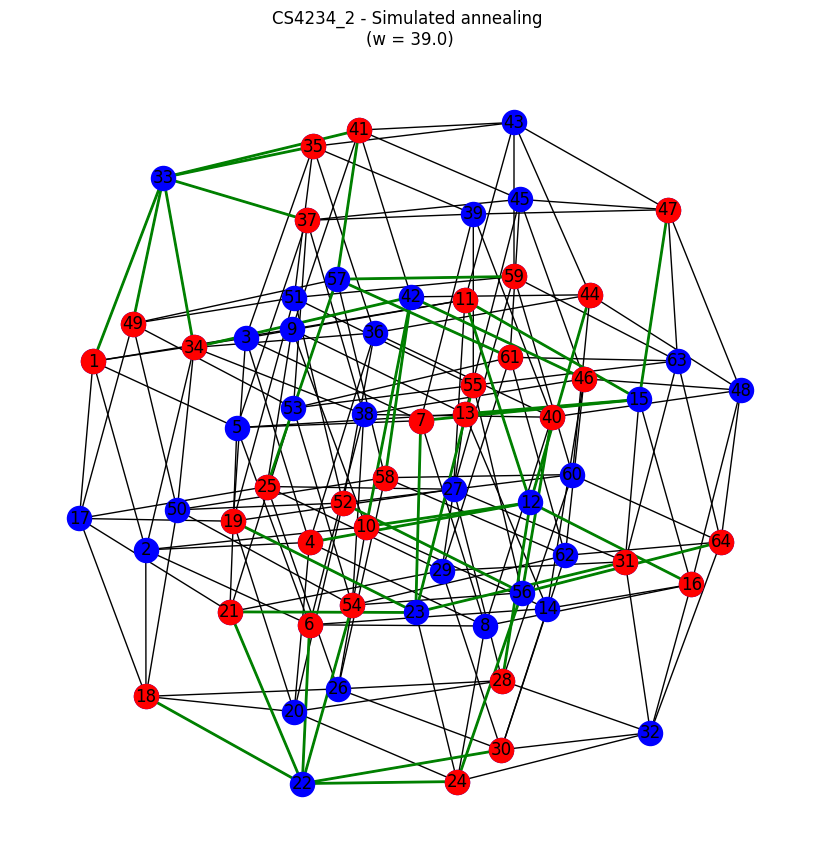

In [99]:
pos = nx.spring_layout(G, seed = 42)
T, w = simulated_annealing(G, terminals, iterations = 10000)
    
plt.figure(figsize = (8,8))
nx.draw(G, pos, with_labels = True, node_color = 'blue')
nx.draw_networkx_edges(T, pos, edge_color = 'green', width = 2)
nx.draw_networkx_nodes(G, pos, nodelist = terminals, node_color = 'red')
    
   # edge_labels = nx.get_edge_attributes(G, "weight") 
   # nx.draw_networkx_edge_labels(G, pos, edge_labels = edge_labels, font_size = 8)  

plt.title(f"{name} - Simulated annealing \n(w = {w})")
plt.show()
#Note: Na 100 iteracija ne moze da dodje do optimalnog - 39, na 1000 moze